In [15]:
%matplotlib notebook
import pandas as pd
import numpy as np
import pyexcel_xlsx
%pylab inline
#%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

Populating the interactive namespace from numpy and matplotlib


In [16]:
pylab.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams.update({'font.size': 25,'legend.fontsize':25, 'lines.markersize' : 15, 'xtick.labelsize': 20, 'ytick.labelsize': 20 })#,'font.family': 'serif'})
rc('axes', linewidth=3)
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import AutoMinorLocator


# Load Data

In [21]:
data = pd.read_excel(r'/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/PYTHON/Master_Haz_Dmg.xlsx')
df = pd.DataFrame(data)
df = df.set_index(['FIPS'])

## Load Vulnerability Data

In [4]:
v_data = pd.read_excel(r'/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/PYTHON/Vulnerability_Indexes.xlsx')
df_v = pd.DataFrame(v_data)
df_v = df_v.set_index(['FIPS'])

In [5]:
df = df.join(df_v)

# Clean and Split Data

In [22]:
df = df.round(2)
list(df)

['TRACT',
 'Prop_SFHA_',
 'Prop_DG_Ar',
 'Ave_LS_cod',
 'HWM_MaxD_1',
 'DG_MaxDe_1',
 'HurTrack_D',
 'PeakGust_1',
 'MaxSusta_1',
 'Idx_AorD',
 'Idx_D',
 'DMG_Index',
 'Count_']

In [23]:
df.DMG_Index.replace(0, .01, inplace = True)
df = df.drop(['TRACT', 'HWM_MaxD_1', 'Idx_D', 'Idx_AorD', 'Var_Name'], axis=1).round(2)

KeyError: "['Var_Name'] not found in axis"

In [8]:
df.describe(include='all')

,Prop_SFHA_,Prop_DG_Ar,Ave_LS_cod,DG_MaxDe_1,HurTrack_D,PeakGust_1,MaxSusta_1,DMG_Index,Count_,StrVI,SeVI,Str+SeVI,SoVI
count,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,885.000000,882.000000,885.000000,882.000000
mean,0.182210,0.058442,1.099425,2.600210,0.225414,52.831127,41.719436,3.564188,1666.792265,0.000023,0.020068,0.020045,-0.005000
std,0.268509,0.159036,0.412070,4.653285,0.127059,8.709637,6.990298,4.631465,957.592920,3.760950,5.450390,6.447660,6.692986
min,0.000000,0.000000,0.000000,0.000000,0.000000,24.590000,19.220000,0.010000,0.000000,-13.150000,-23.740000,-32.430000,-31.560000
25%,0.000000,0.000000,1.000000,0.000000,0.130000,45.150000,35.760000,0.680000,971.000000,-2.620000,-3.087500,-3.320000,-4.537500
50%,0.050000,0.000000,1.000000,0.000000,0.220000,56.330000,44.700000,2.290000,1510.000000,-0.190000,0.630000,0.330000,0.310000
75%,0.230000,0.020000,1.250000,4.430000,0.290000,60.350000,47.390000,4.810000,2285.000000,2.410000,3.697500,4.010000,4.372500
max,1.000000,1.000000,3.000000,61.940000,0.920000,65.710000,54.540000,56.000000,7069.000000,16.520000,15.220000,18.110000,25.160000


### Identify and remove null values

In [9]:
df.isnull().sum()

Prop_SFHA_     0
Prop_DG_Ar     0
Ave_LS_cod     0
DG_MaxDe_1     0
HurTrack_D     0
PeakGust_1     0
MaxSusta_1     0
DMG_Index      0
Count_         0
StrVI         20
SeVI          23
Str+SeVI      20
SoVI          23
dtype: int64

In [10]:
nullvalues = df.loc[pd.isnull(df).any(1),:]

In [11]:
df = df.dropna()

In [12]:
df.to_excel("/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/PYTHON/CleanDatafor_JMP.xlsx") 

## Partition to x and y variables, train/test split

In [90]:
df_x = df.drop(['DMG_Index'], axis=1)
df_y = df.DMG_Index

In [91]:
df_x.head()

,Prop_SFHA_,Prop_DG_Ar,Ave_LS_cod,DG_MaxDe_1,HurTrack_D,PeakGust_1,MaxSusta_1,Count_,StrVI,SeVI,Str+SeVI,SoVI
FIPS,,,,,,,,,,,,
72001956300,0.02,0.00,2.00,0.00,0.24,44.26,34.87,2414,3.07,-8.41,-5.35,-9.44
72001956400,0.03,0.02,2.00,2.72,0.27,43.81,33.98,1854,7.84,-7.49,0.35,-14.31
72001956500,0.01,0.00,1.88,0.00,0.29,43.36,33.98,1833,5.42,-13.13,-7.71,-8.48
72001956600,0.05,0.00,1.80,0.00,0.26,43.81,34.42,698,1.21,-7.72,-6.51,-7.78
72001956700,0.10,0.00,2.00,0.00,0.26,43.81,34.42,790,1.30,-6.66,-5.35,-6.12


In [92]:
df_y.head()

FIPS
72001956300    0.01
72001956400    1.78
72001956500    0.71
72001956600    0.01
72001956700    0.01
Name: DMG_Index, dtype: float64

In [93]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

### SET RANDOM STATE TO GET REPRODUCIBLE RESULTS, otherwise can randomizeas default is none

In [94]:
rf = RandomForestRegressor(random_state = 42)
print(rf.get_params)

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)>


# Optimize Hyperparameters

## RandomizedSearchCV to narrow range of hyperparameters

In [95]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)



{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [96]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using cv = cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [97]:
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV]  n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40, total=   4.3s
[CV] n_estimators=1788, min_sa

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.8s


[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   2.4s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   2.3s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   2.4s
[CV] n_estimators=1577, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100 
[CV]  n_estimators=1788, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, total=   7.3s
[CV] n_estimators=1577, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   2.2s
[CV] n_estimators=1577, min_samples

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min


[CV]  n_estimators=1155, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, total=   5.1s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=1155, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, total=   5.2s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=1155, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, total=   5.1s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, total=   5.7s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, total=   5.6s
[CV] n_estimators=522, min_samples_

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.0min


[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=50, total=   6.4s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   4.3s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, total=   3.4s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   4.4s
[CV] n_estimators=944, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=40 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   4.3s
[CV] n_estimators=944, min_samples_split

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.2min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [98]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 110}

In [99]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(np.mean(errors)))
    #print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return errors
    return mape
    return accuracy
    

In [100]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)



best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_test, y_test)



Model Performance
Average Error: 2.8191.
Model Performance
Average Error: 2.5480.


In [101]:
best_random.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=110,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

In [102]:
base_model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)>

## GridSearchCV to iterate over the options

In [103]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 

param_grid = {
    'max_depth': [90, 100, 110, 120],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [90, 100, 200, 400]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [104]:
# Fit the grid search to the data
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=90 
[CV] max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=90 
[CV] max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=90 
[CV] max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=90 
[CV] max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=90 
[CV] max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=90, total=   0.2s
[CV] max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_est

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s


[CV]  max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.0s
[CV] max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, total=   1.1s
[CV] max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.8s


[CV]  max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400, total=   1.0s
[CV] max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV] max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=90 
[CV]  max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimat

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   24.9s


[CV]  max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV]  max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV] max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV]  max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=90 
[CV] max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=90 
[CV]  max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   48.7s


[CV]  max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=90 
[CV]  max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=90, total=   0.3s
[CV] max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=90 
[CV]  max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=90, total=   0.3s
[CV] max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=90 
[CV]  max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=90, total=   0.2s
[CV] max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=90, total=   0.2s
[CV] max_depth=100, max_features=2, min_samples_leaf=4, min_samples_

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.3min


[CV]  max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=90, total=   0.3s
[CV] max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=90, total=   0.3s
[CV] max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV]  max_depth=100, max_features=4, min_samples_leaf=4, min_sa

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.9min


[CV]  max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400, total=   1.3s
[CV] max_depth=110, max_features=4, min_samples_leaf=3, min_samples_s

[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  2.7min


[CV]  max_depth=120, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] max_depth=120, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  max_depth=120, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] max_depth=120, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  max_depth=120, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] max_depth=120, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=90 
[CV]  max_depth=120, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] max_depth=120, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=90 
[CV]  max_depth=120, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] max_depth=120, max_features=4, min_samples_leaf=3, min_sampl

[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [90, 100, 110, 120], 'max_features': [2, 3, 4], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [90, 100, 200, 400]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [105]:
grid_search.best_params_

{'max_depth': 110,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

In [106]:
best_grid = grid_search.best_estimator_

In [107]:
grid_accuracy = evaluate(best_grid, x_train, y_train)

Model Performance
Average Error: 1.7164.


In [108]:
model = best_grid

# Look at Performance More

In [109]:
base_model.score(x_train, y_train)

0.80138748866421872

In [110]:
base_model.score(x_test, y_test)

-0.063589335844123962

In [111]:
model.score(x_train, y_train)

0.53970501568314466

In [112]:
model.score(x_test, y_test)

0.12569671835161755

In [113]:
pred = model.predict(x_test)

In [114]:
mse = mean_squared_error(y_test, pred)
mse

11.337452832201548

In [115]:
errors = pred - y_test
errors
meanerror = np.mean(errors)
meanerror

0.0021908745815104277

In [116]:
meanabserrors = np.mean(abs(pred - y_test))
meanabserrors

2.5753466237334459

In [117]:
def getrange(numbers):
    return max(numbers) - min(numbers)

print(getrange(errors))
print(max(errors))
print(min(errors))

19.80404809057987
6.394333539222214
-13.409714551357654


# Cheat a bit and arrange things in excel because I am lazy

In [133]:
pred_look = pd.DataFrame(pred)

pred_look.to_excel(excel_writer= "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/PYTHON/pred_look_20191008.xlsx")

In [134]:
true_look = pd.DataFrame(y_test)
true_look.to_excel(excel_writer= "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/PYTHON/true_look_20191008.xlsx")

In [135]:
#reimport

data2 = pd.read_excel(r'/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/PYTHON/DMGIndex_Pred_20191008.xlsx')
df2 = pd.DataFrame(data2)
df2 = df2.set_index('FIPS')
df2

true = df2['DMG_Index']
prediction = df2['Pred']

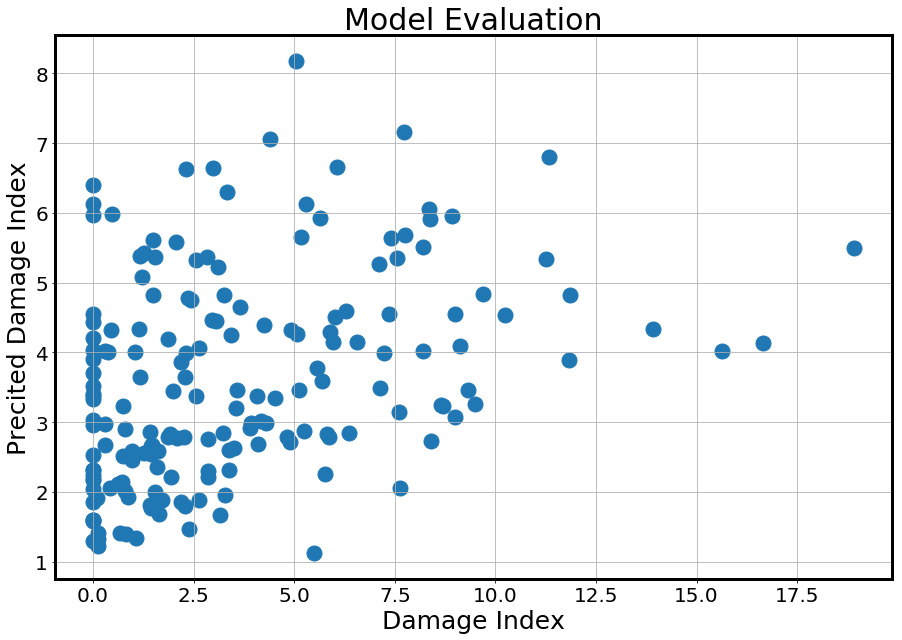

In [136]:
plt.figure()
plt.scatter(df2.DMG_Index, df2.Pred)
plt.xlabel("Damage Index")
plt.ylabel("Precited Damage Index")
plt.title('Model Evaluation')
plt.grid(True)



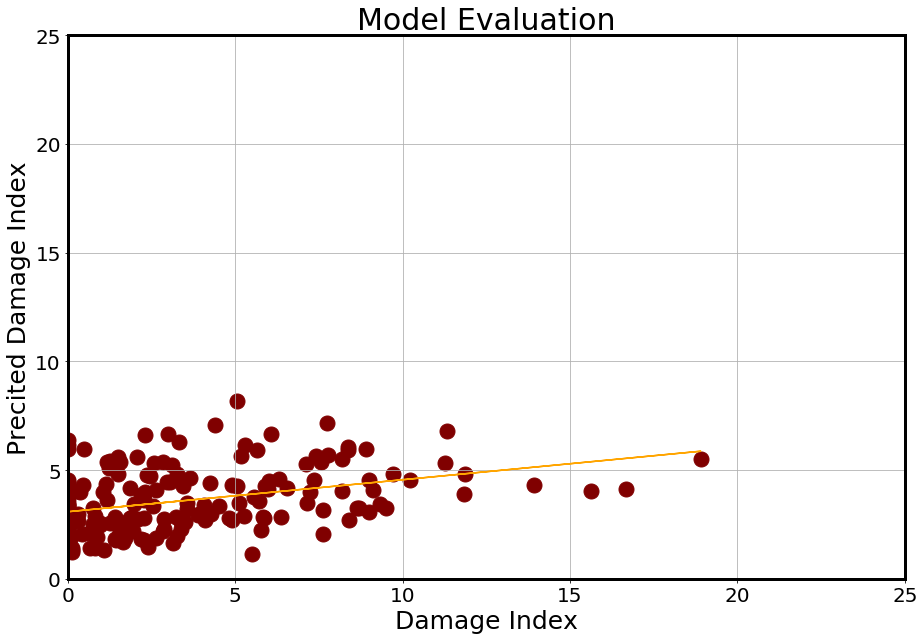

In [151]:
from sklearn.linear_model import LinearRegression

X = df2.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df2.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column


linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y, color='maroon')
plt.plot(X, Y_pred, color='orange')
plt.grid(True)
plt.xlabel("Damage Index")
plt.ylabel("Precited Damage Index")
plt.title('Model Evaluation')
plt.xlim(0,25)
plt.ylim(0,25)

plt.savefig('/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/PYTHON/ME_20181008')

plt.show()



In [138]:
from sklearn.metrics import r2_score
r2_score(X, Y) 

0.12569671835161755

# Feature Importances

In [139]:
importances = model.feature_importances_
importance_d = pd.DataFrame(importances, index = x_train.columns, columns=['importance']).sort_values('importance', ascending=False)

std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 7 (0.127069)
2. feature 9 (0.115441)
3. feature 8 (0.108110)
4. feature 4 (0.099720)
5. feature 11 (0.099539)
6. feature 5 (0.088006)
7. feature 10 (0.084192)
8. feature 6 (0.083199)
9. feature 2 (0.062371)
10. feature 0 (0.052828)
11. feature 3 (0.046295)
12. feature 1 (0.033232)


In [140]:
importance_d

,importance
Count_,0.127069
SeVI,0.115441
StrVI,0.108110
HurTrack_D,0.099720
SoVI,0.099539
PeakGust_1,0.088006
Str+SeVI,0.084192
MaxSusta_1,0.083199
Ave_LS_cod,0.062371
Prop_SFHA_,0.052828


In [149]:
label = ['Count', 'SeVI', 'StrVI', 'HurTrack_D', 'SoVI', 'PeakGust', 'Str+SeVI', 'MaxSusta',  'Av_LS_Cod', 'P_SFHA', 'DG_MaxDe', 'P_DG_Ar']

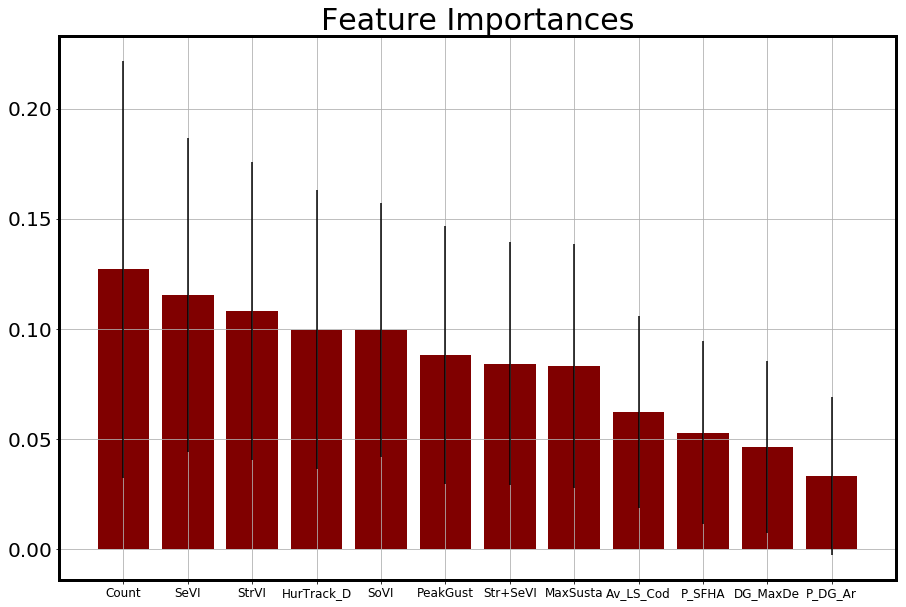

In [150]:
plt.figure()
plt.title("Feature Importances", fontsize = 30)
plt.bar(range(x_train.shape[1]), importances[indices],
       yerr=std[indices], align="center", color='maroon')
plt.xticks(range(x_train.shape[1]), label, fontsize = 12)
#plt.xlabel(importance_d.index)
plt.xlim([-1, x_train.shape[1]])
plt.grid(True)

plt.savefig('/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/PYTHON/FI_20191008')



# Visualize a tree

In [282]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = model.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

feature_list = list(df_x.columns)


# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
#Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [287]:
x_train

,Prop_SFHA_,Prop_DG_Ar,Ave_LS_cod,DG_MaxDe_1,HurTrack_D,PeakGust_1,MaxSusta_1,Count_
FIPS,,,,,,,,
72117959600,0.00,0.00,1.00,0.00,0.36,35.76,28.16,3404
72113070503,0.33,0.00,1.00,2.49,0.35,42.92,33.53,1145
72039955800,0.04,0.02,1.50,9.10,0.05,51.86,40.68,2633
72133953600,0.21,0.01,0.82,9.51,0.28,46.49,36.21,2795
72071410600,0.00,0.00,1.09,7.86,0.15,42.02,33.08,2933
72021032302,0.00,0.00,1.75,4.51,0.12,57.67,45.15,1160
72057270400,0.16,0.00,1.00,0.00,0.13,53.20,41.57,1392
72031050242,0.12,0.00,1.00,0.00,0.29,59.90,46.94,1816
72017590200,0.72,0.30,0.67,6.45,0.07,51.86,41.57,1764
